## Синтез изображений. Генеративно-Состязательная Сеть (GAN)

In [1]:
%tensorflow_version 2.x

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
# Загрузка датасета LFW
train_ds_unbatched, train_info = tfds.load('lfw', split='train[:80%]', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/lfw/0.1.0.incompleteV4L0JX/lfw-train.tfrecord


Dataset lfw downloaded and prepared to /root/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


In [4]:
train_ds_unbatched

<PrefetchDataset shapes: {image: (250, 250, 3), label: ()}, types: {image: tf.uint8, label: tf.string}>

In [5]:
train_info

tfds.core.DatasetInfo(
    name='lfw',
    version=0.1.0,
    description='Labeled Faces in the Wild:
        A Database for Studying Face Recognition in
        Unconstrained Environments',
    homepage='http://vis-www.cs.umass.edu/lfw',
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=13233,
    splits={
        'train': 13233,
    },
    supervised_keys=('label', 'image'),
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 2007,
        number = {07-49},
        month = {October}
    }""",
    redistribution_info=,
)

In [58]:
INP_SIZE = 64

train_x = []
for k, ds in enumerate(train_ds_unbatched):
    #pprint(ds)
    img = (ds['image'].numpy().astype(np.float32)  - 127.5) / 127.5
    img = tf.image.resize(img, (INP_SIZE, INP_SIZE))
    train_x.append(img)
    if k >= 4999:
        break
train_x = np.array(train_x)
print(train_x.shape, train_x.dtype)
print(np.min(train_x), np.max(train_x))

(5000, 64, 64, 3) float32
-1.0 1.0


## Визуализация датасета LFW

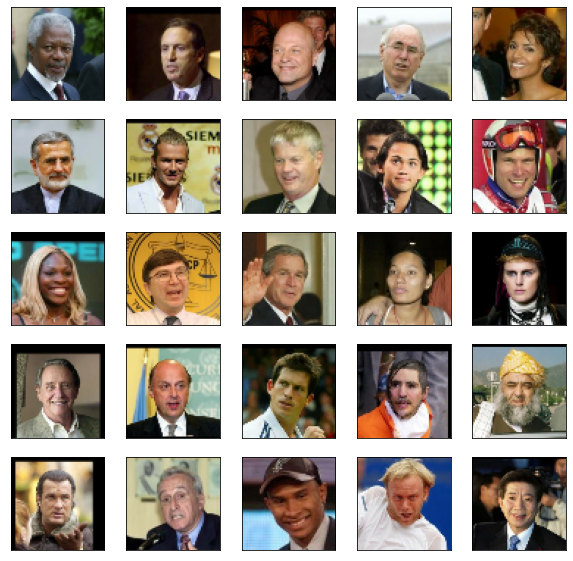

In [59]:
def plot_digits(samples):
    fig = plt.figure(figsize=(10, 10))
    num = samples.shape[0]
    for j in range(num):
        ax = fig.add_subplot(5, 5, j+1)
        ax.imshow((samples[j, ...] * 127.5 + 127.5).astype(np.uint8))
        plt.xticks([]), plt.yticks([])
    plt.show()
    
plot_digits(train_x[50:75, ...])

In [60]:
train_x.shape

(5000, 64, 64, 3)

## Создание Генератора и Дискриминатора

In [61]:
# Deep Convolutional GAN (DCGAN)
generator = tf.keras.Sequential([
    # 4x4x512 -> 8x8x512
    tf.keras.layers.Dense(512 * 4 * 4, activation='relu'),
    tf.keras.layers.Reshape((4, 4, 512)),
    tf.keras.layers.UpSampling2D((2, 2)),    
    # 8x8x512 -> 16x16x256
    tf.keras.layers.Conv2D(256, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),    
    tf.keras.layers.UpSampling2D((2, 2)),    
    # 16x16x256 -> 32x32x128
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),    
    tf.keras.layers.UpSampling2D((2, 2)),
    # 32x32x128 -> 64x64x64
    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.UpSampling2D((2, 2)),
    # 64x64x64 -> 64x64x3
    tf.keras.layers.Conv2D(3, (3, 3), padding='same', activation='tanh'),
])

discriminator = tf.keras.Sequential([
    # 64*64*3 -> 32x32x64
    tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.25),
    # 32*32*64 -> 16x16x128
    tf.keras.layers.Conv2D(128, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1))),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    # 16*16*128 -> 8x8x256
    tf.keras.layers.Conv2D(256, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    # 8*8*256 -> 4x4x512
    tf.keras.layers.Conv2D(512, kernel_size=3, strides=(1, 1), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
])

In [62]:
INPUT_DIM = 100
NUM_EPOCHS = 120
HALF_BATCH_SIZE = 16
BATCH_SIZE = HALF_BATCH_SIZE * 2
LEARNING_RATE = 0.0002

train_ds = tf.data.Dataset.from_tensor_slices(train_x.reshape(-1, 64, 64, 3))
train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

[Step  0] D Loss: 1.1271; G Loss: 0.6216


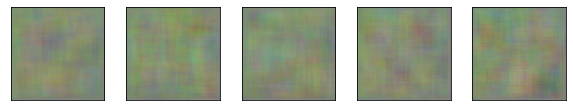

[Step 500] D Loss: 0.6732; G Loss: 11.3416


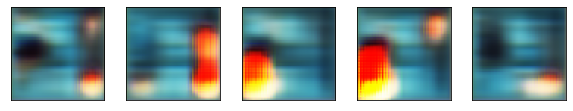

[Step 1000] D Loss: 0.0027; G Loss: 12.5612


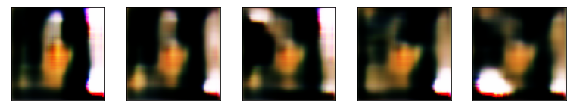

[Step 1500] D Loss: 0.0004; G Loss: 17.8692


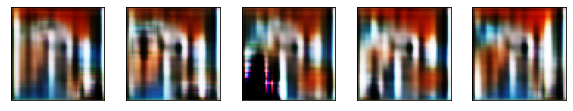

[Step 2000] D Loss: 0.0010; G Loss: 4.4011


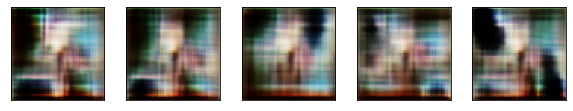

[Step 2500] D Loss: 0.0627; G Loss: 11.0943


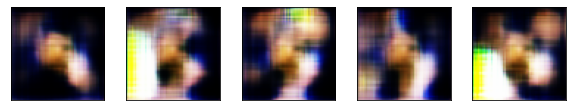

[Step 3000] D Loss: 0.5518; G Loss: 11.5101


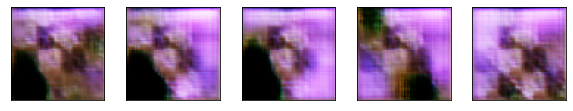

[Step 3500] D Loss: 0.0000; G Loss: 14.4148


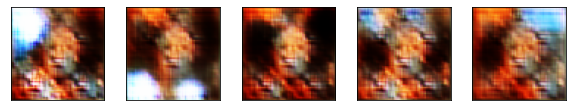

[Step 4000] D Loss: 0.0053; G Loss: 11.5107


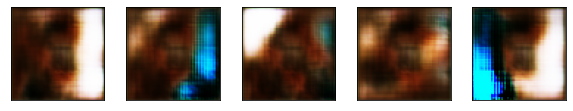

[Step 4500] D Loss: 0.7582; G Loss: 19.2642


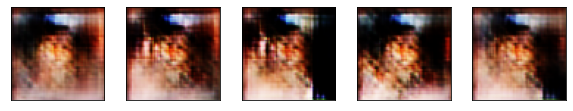

[Step 5000] D Loss: 0.0000; G Loss: 23.4507


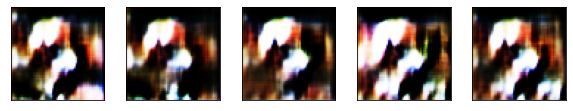

[Step 5500] D Loss: 0.0000; G Loss: 21.7669


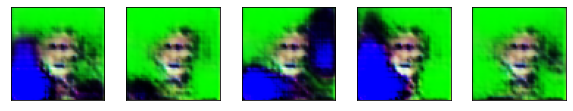

[Step 6000] D Loss: 0.0089; G Loss: 13.9018


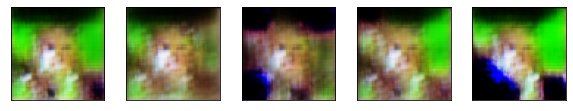

[Step 6500] D Loss: 0.2627; G Loss: 41.5506


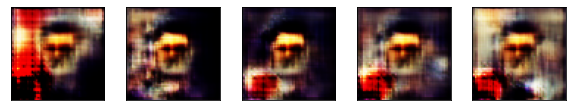

[Step 7000] D Loss: 0.0026; G Loss: 10.4857


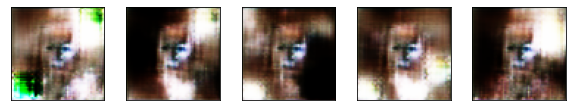

[Step 7500] D Loss: 0.3681; G Loss: 19.0157


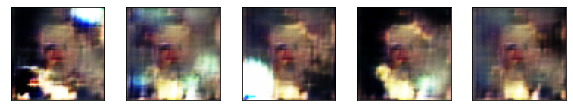

[Step 8000] D Loss: 0.1513; G Loss: 9.4554


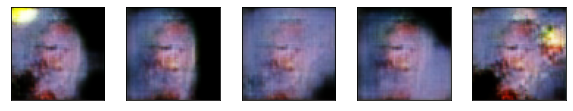

[Step 8500] D Loss: 0.0002; G Loss: 17.5030


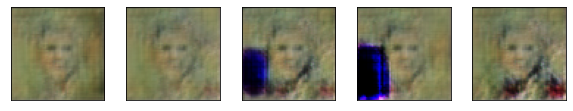

[Step 9000] D Loss: 0.2186; G Loss: 17.2135


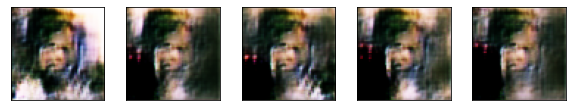

[Step 9500] D Loss: 0.4726; G Loss: 17.6143


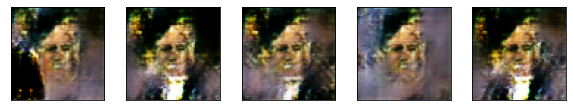

[Step 10000] D Loss: 0.0040; G Loss: 27.4589


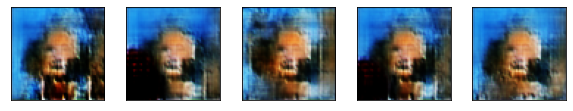

[Step 10500] D Loss: 0.0001; G Loss: 14.7302


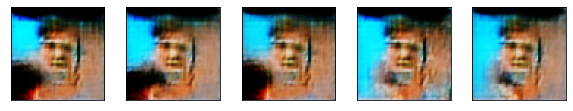

[Step 11000] D Loss: 0.4609; G Loss: 23.6101


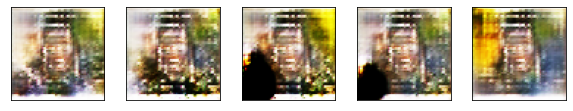

[Step 11500] D Loss: 0.0186; G Loss: 17.5564


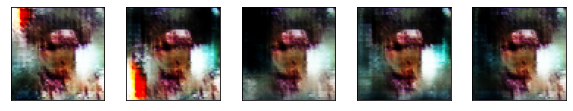

[Step 12000] D Loss: 0.0310; G Loss: 13.2430


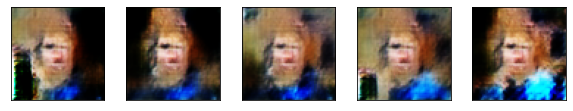

[Step 12500] D Loss: 0.3457; G Loss: 21.3416


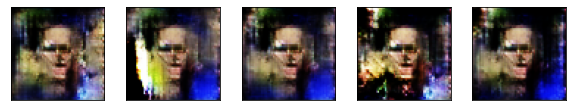

[Step 13000] D Loss: 0.1436; G Loss: 11.5565


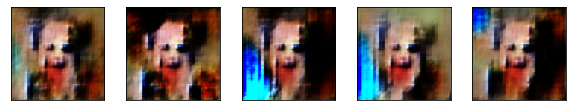

[Step 13500] D Loss: 0.0002; G Loss: 19.4449


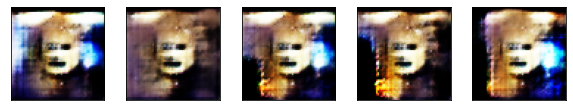

[Step 14000] D Loss: 0.2163; G Loss: 16.4391


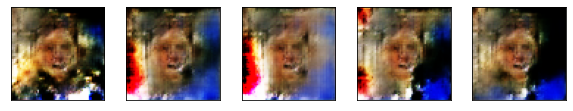

[Step 14500] D Loss: 0.3023; G Loss: 12.9196


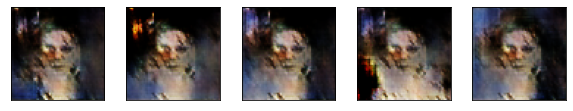

[Step 15000] D Loss: 0.0091; G Loss: 21.1245


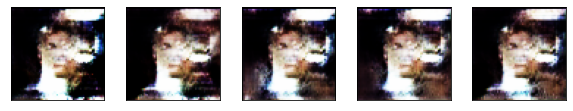

[Step 15500] D Loss: 0.0464; G Loss: 23.5783


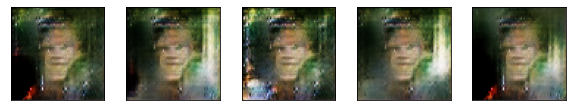

[Step 16000] D Loss: 0.1023; G Loss: 29.0035


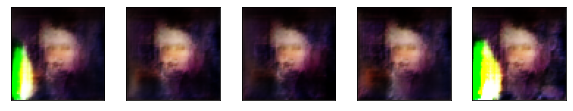

[Step 16500] D Loss: 0.0120; G Loss: 12.1378


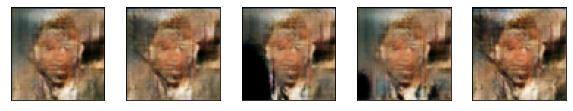

[Step 17000] D Loss: 0.0370; G Loss: 22.3987


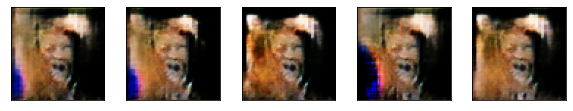

[Step 17500] D Loss: 0.0318; G Loss: 21.8852


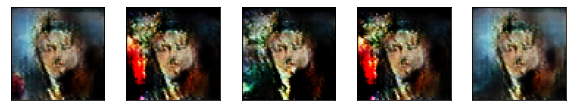

[Step 18000] D Loss: 0.0214; G Loss: 22.3351


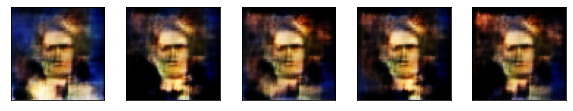

[Step 18500] D Loss: 0.0004; G Loss: 22.8075


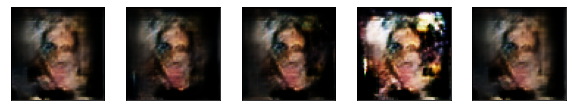

[Step 19000] D Loss: 0.0001; G Loss: 20.5494


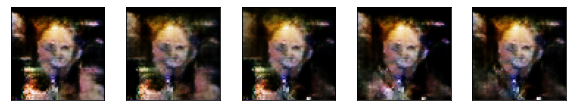

[Step 19500] D Loss: 0.0284; G Loss: 16.8762


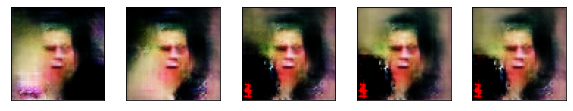

[Step 20000] D Loss: 0.0015; G Loss: 19.5351


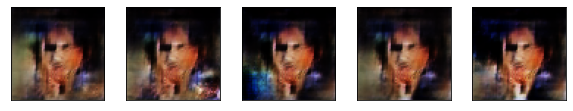

[Step 20500] D Loss: 0.2255; G Loss: 11.9855


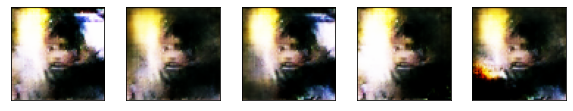

[Step 21000] D Loss: 0.2403; G Loss: 3.3529


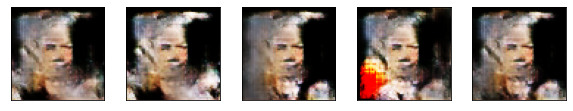

[Step 21500] D Loss: 0.0946; G Loss: 19.6933


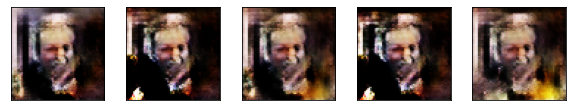

[Step 22000] D Loss: 0.0972; G Loss: 14.1443


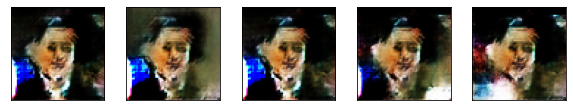

[Step 22500] D Loss: 0.0252; G Loss: 18.6402


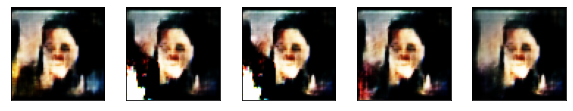

[Step 23000] D Loss: 0.0004; G Loss: 18.7709


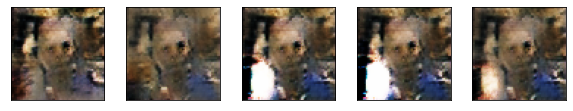

[Step 23500] D Loss: 0.0011; G Loss: 21.1941


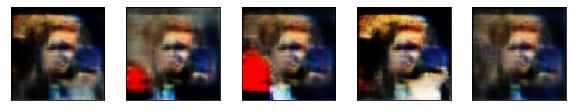

[Step 24000] D Loss: 0.0359; G Loss: 19.4635


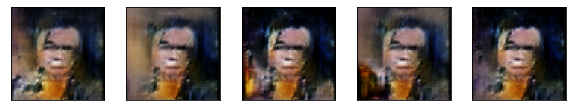

[Step 24500] D Loss: 0.2232; G Loss: 14.8673


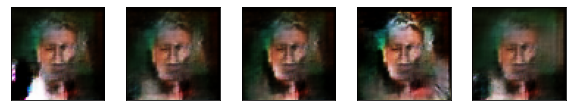

[Step 25000] D Loss: 0.0549; G Loss: 15.3984


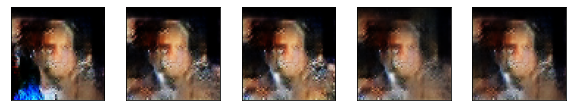

[Step 25500] D Loss: 0.2199; G Loss: 23.2097


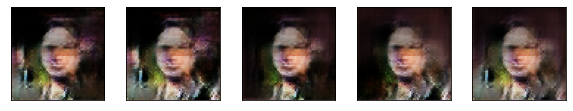

[Step 26000] D Loss: 0.0033; G Loss: 25.5051


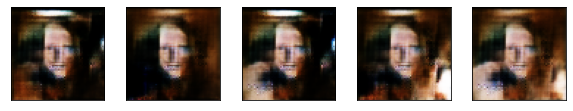

[Step 26500] D Loss: 0.0009; G Loss: 28.6299


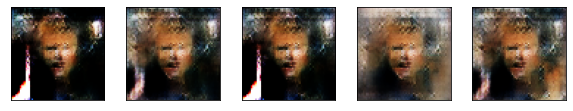

[Step 27000] D Loss: 0.0634; G Loss: 15.1762


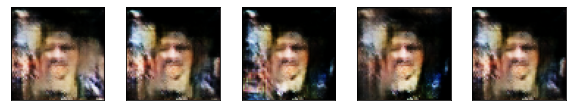

[Step 27500] D Loss: 0.0048; G Loss: 27.1050


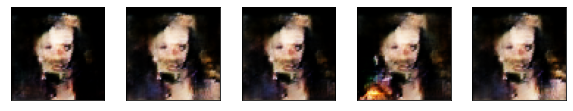

[Step 28000] D Loss: 0.0023; G Loss: 16.2452


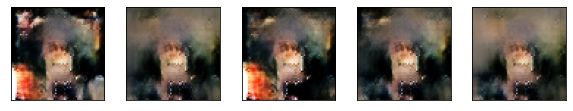

[Step 28500] D Loss: 0.0068; G Loss: 10.3477


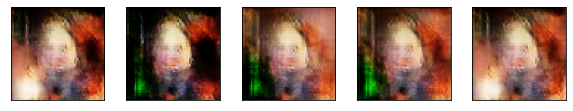

[Step 29000] D Loss: 0.0038; G Loss: 14.4551


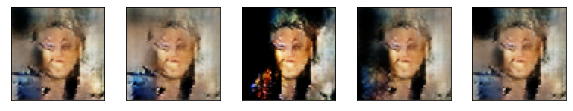

[Step 29500] D Loss: 0.1618; G Loss: 11.7775


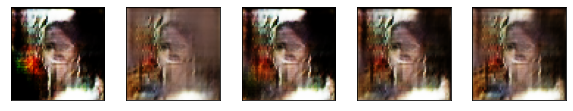

[Step 30000] D Loss: 0.0461; G Loss: 13.8420


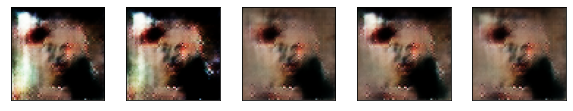

[Step 30500] D Loss: 0.0018; G Loss: 16.6135


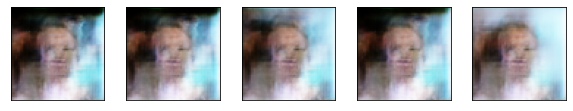

[Step 31000] D Loss: 0.4504; G Loss: 14.6475


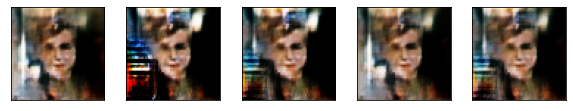

[Step 31500] D Loss: 0.0009; G Loss: 12.7735


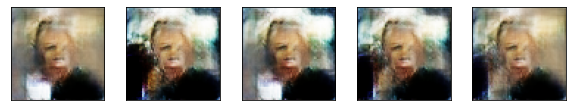

[Step 32000] D Loss: 0.1222; G Loss: 25.3545


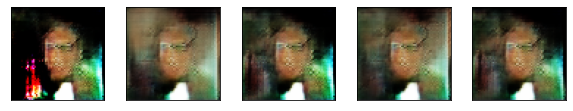

[Step 32500] D Loss: 0.0018; G Loss: 20.4487


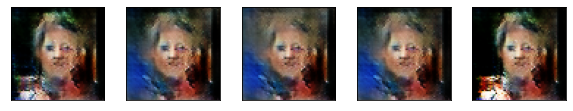

[Step 33000] D Loss: 0.0028; G Loss: 21.3789


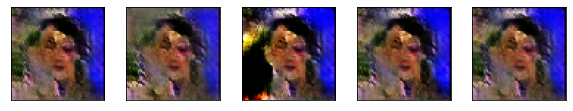

[Step 33500] D Loss: 0.2835; G Loss: 23.0591


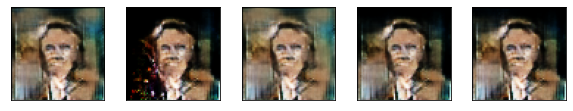

[Step 34000] D Loss: 0.2168; G Loss: 10.0184


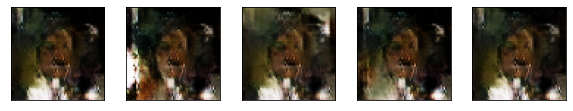

[Step 34500] D Loss: 0.0270; G Loss: 12.2426


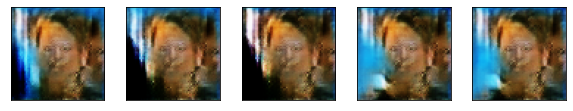

[Step 35000] D Loss: 0.0353; G Loss: 24.8243


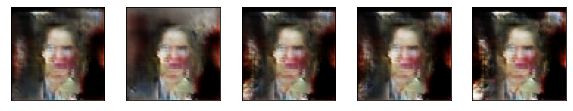

[Step 35500] D Loss: 0.0002; G Loss: 12.6166


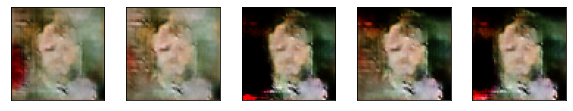

[Step 36000] D Loss: 0.0011; G Loss: 15.6811


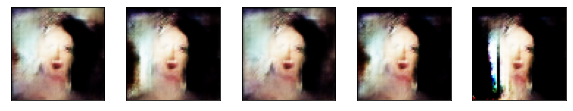

[Step 36500] D Loss: 0.0028; G Loss: 17.0432


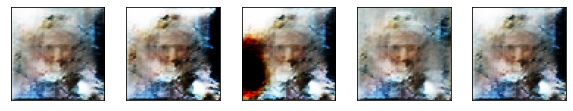

[Step 37000] D Loss: 0.1468; G Loss: 27.4961


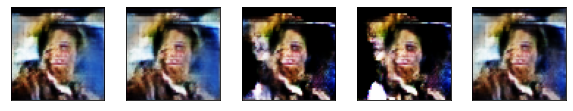

In [63]:
for step, true_images in enumerate(train_ds):
    
    # Train Discriminator
    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise)
    x_combined = np.concatenate((
        true_images, 
        syntetic_images))
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1), np.float32), 
        np.zeros((HALF_BATCH_SIZE, 1), np.float32)))
    
    with tf.GradientTape() as tape:
        logits = discriminator(x_combined, training=True)
        d_loss_value = sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    # Train Generator
    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)
    
    with tf.GradientTape() as tape:
        syntetic = generator(noise, training=True)
        logits = discriminator(syntetic, training=False)
        g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    # Check intermediate results
    if step % 500 == 0:
        print('[Step %2d] D Loss: %.4f; G Loss: %.4f' % (
            step, d_loss_value.numpy(), g_loss_value.numpy()))
        noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_digits(syntetic_images[:5])


## Тестирование свёрточного генератора

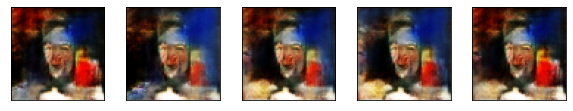

In [67]:
np.random.seed(42)
noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
plot_digits(syntetic_images[:5])

## Интерполяция в латентном пространстве

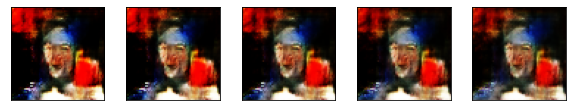

In [71]:
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 8)
syntetic_images = generator.predict(noise)
plot_digits(syntetic_images[:5])

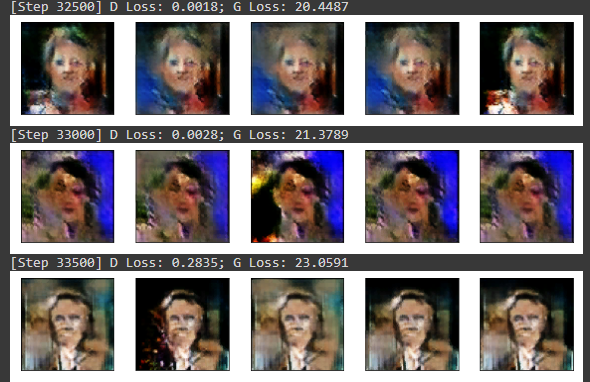

In [72]:
from IPython.display import Image
Image("rezult.png")